<a href="https://colab.research.google.com/github/atuchiya/gf180-analog-tutorial/blob/main/mosfet_gf180.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning MOSFET Characteristics with ngspice

## 1. Introduction

This notebook is a guide to understand MOSFET characteristics in GlobalFoundries 180-nm CMOS ([gf180mcu](https://gf180mcu-pdk.readthedocs.io/en/latest/)). This document covers two design environments:
- ngspice in jupyter-notebook (this notebook)
- Xschem + ngspice in [IIC-OSIC-TOOLS](https://github.com/iic-jku/IIC-OSIC-TOOLS) by JKU
If you use Xschem, download Xschem schematic files (*.sch) from github repository.

### 1.1 Notation Rules

In thsi document, basic notation rule is as follows
- Upper case means large signal (including nonlinear effect). i.e. $V$, $I$, $R$, etc.
- Lower case means small signal (linear approximation), i.e. $v$, $i$, $r$, etc.
- Voltage $V$ with subscription, for example $V_{\mathrm{AB}}$, means voltage difference from node B to node A. Thus, $V_{\mathrm{AB}}=-V_{\mathrm{BA}}$.
- Some special variables:
  - $V_{\mathrm{DD}}$ : the supply voltage
  - $V_{\mathrm{SS}}$ : the common voltage (usually, equal to ground voltage (0 V))






##2. Installing ngspice and PDK

Simulation setup is adopted from [IEEE SSCS OSE Chipathon template](https://github.com/sscs-ose/sscs-ose-chipathon.github.io/blob/main/template_notebook_to_follow.ipynb)

In [87]:
#@title Install dependencies {display-mode: "form"}
#@markdown - Click the ▷ button to setup the digital design environment based on [conda-eda](https://github.com/hdl/conda-eda).

ngspice_version = 'latest' #@param {type:"string"}
gf180mcu_fd_pr_version = 'latest' #@param {type:"string"}

if ngspice_version == 'latest':
  ngspice_version = ''

if gf180mcu_fd_pr_version == 'latest':
  gf180mcu_fd_pr_version = 'main'

import os
import pathlib
import urllib.request

!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
CONDA_PREFIX = str(conda_prefix_path.resolve())
!bin/micromamba create --yes --prefix $CONDA_PREFIX
!echo 'python ==3.7*' >> {CONDA_PREFIX}/conda-meta/pinned
!CI=0 bin/micromamba install --yes --prefix $CONDA_PREFIX \
                     --channel litex-hub \
                     --channel main \
                     ngspice={ngspice_version}

ngspice_models_dir = pathlib.Path('globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice')
ngspice_models_dir.mkdir(exist_ok=True, parents=True)
models = ['design.ngspice', 'sm141064.ngspice', 'sm141064_mim.ngspice', 'smbb000149.ngspice']
for m in models:
  url = f'https://github.com/efabless/globalfoundries-pdk-libs-gf180mcu_fd_pr/raw/{gf180mcu_fd_pr_version}/models/ngspice/{m}'
  print('downloading:', url)
  with urllib.request.urlopen(url) as src:
    with (ngspice_models_dir / m).open('wb') as dst:
      dst.write(src.read())

PATH = os.environ['PATH']
%env CONDA_PREFIX={CONDA_PREFIX}
%env PATH={CONDA_PREFIX}/bin:{PATH}

Empty environment created at prefix: /content/conda-env

Pinned packages:

  - python==3.7*


Transaction

  Prefix: /content/conda-env

  Updating specs:

   - ngspice


  Package                      Version  Build            Channel         Size
───────────────────────────────────────────────────────────────────────────────
  Install:
───────────────────────────────────────────────────────────────────────────────

  + _libgcc_mutex                  0.1  main             main          Cached
  + _openmp_mutex                  5.1  1_gnu            main          Cached
  + libgcc-ng                   11.2.0  h1234567_1       main          Cached
  + libgomp                     11.2.0  h1234567_1       main          Cached
  + libstdcxx-ng                11.2.0  h1234567_1       main          Cached
  + ngspice        39.3_552_g902a62d2f  20240223_100318  litex-hub     Cached

  Summary:

  Install: 6 packages

  Total download: 0 B

────────────────────────────────────────────────────

In [88]:
%%writefile .spiceinit
set ngbehavior=hs

Overwriting .spiceinit


In [89]:
import math
import pandas as pd
import matplotlib.pyplot as plt

##3. ID-VGS Characteristics

###3.1 ID-VGS of nMOS

The gate-source voltage $V_{\mathrm{GS}}$ is zero, channel region of nMOS is p-type semiconductor. There is no conduction path between the source and the drain, so the drain current $I_{\mathrm{D}}$ is almost zero (cut-off region).
As $V_{\mathrm{GS}}$ increases, the channel region becomes depletion and finally inverts to n-type semiconductor.  The threshold voltage $V_{\mathrm{th}}$ is the gate-source voltage required to invert the channel region.
If $V_{\mathrm{GS}}>V_{\mathrm{th}}$, the drain current flows.

To investigate this behavior, you can use DC analysis of SPICE.
The spice input file (netlist) is as follows:

In [90]:
%%writefile nfet_03v3_idvgs.spice
* nMOS ID-VGS

.include "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/design.ngspice"
.lib "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/sm141064.ngspice" typical

XM1 net1 G GND B nfet_03v3 L=0.28u W=0.22u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u' pd='2*int((nf+1)/2) * (W/nf + 0.18u)'
+ ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W' sa=0 sb=0 sd=0 m=1
VBS B GND 0
VGS G GND 1.5
VDS D GND 1.5
Vid D net1 0

.option savecurrent
.control
save all
dc VGS 0 3.3 0.01
wrdata nfet_03v3_idvgs.txt i(Vid)
.endc
.end

Overwriting nfet_03v3_idvgs.spice


Note: in SPICE, a line of 'M*name* *drain* *gate* *source* *backgate* *model* *parameters*' is used for MOSFET devices. However in gf180 PDK, MOSFET devices are provided as subcircuits. So, 'X*name* ...' is used for define MOSFETs.

This SPICE netlist sweeps VGS from 0 V to 3.3 V, and write i(Vid) to a file.

Now you can run ngspice

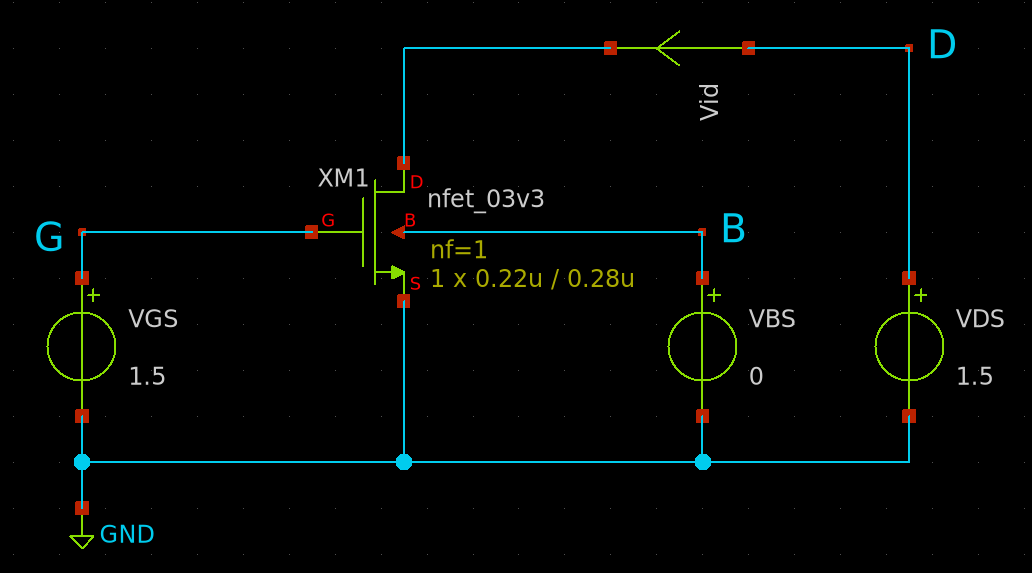

In [91]:
!ngspice -b nfet_03v3_idvgs.spice


Note: Compatibility modes selected: hs



Circuit: * nmos id-vgs

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


No. of Data Rows : 331
Note: Simulation executed from .control section 


In Python, one easy way is to read the results into DataFrame in Pandas.

/tmp/ipython-input-92-1084327039.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("nfet_03v3_idvgs.txt", delim_whitespace=True, header=None)


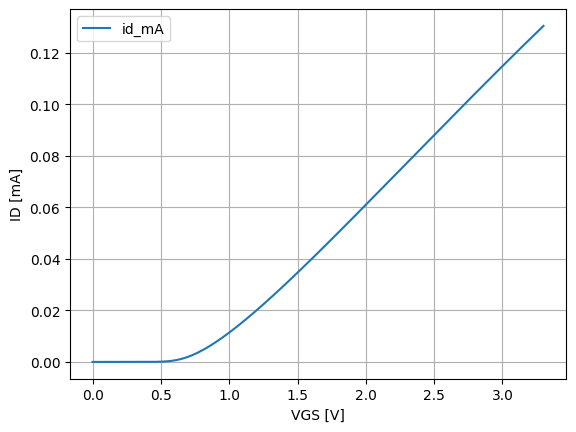

In [92]:
df = pd.read_csv("nfet_03v3_idvgs.txt", delim_whitespace=True, header=None)
df.columns = ["vgs", "id"]
df['id_mA'] = df['id'] * 1000


plt.plot(df['vgs'], df['id_mA'], label='id_mA')
plt.xlabel("VGS [V]")
plt.ylabel("ID [mA]")
plt.legend()
plt.grid(True)
plt.show()

Above $V_{\mathrm{th}}$, $I_{\mathrm{D}}$ increases as $V_{\mathrm{GS}}$ increases.
In the graph above, $I_{\mathrm{D}}$ looks zero below about 0.6 V.
But, it is not completely cut off. Plot in log-scale is:

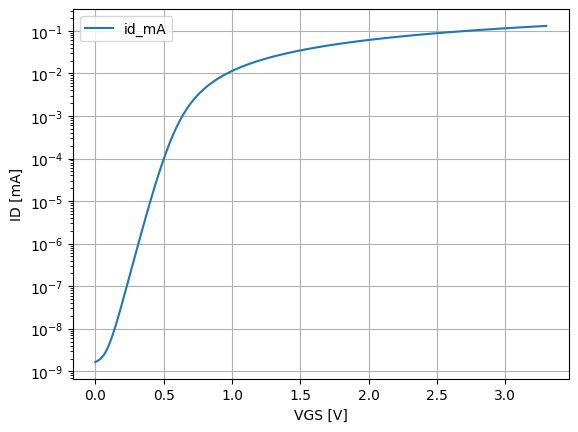

In [93]:
plt.plot(df['vgs'], df['id_mA'], label='id_mA')
plt.yscale('log')
plt.xlabel("VGS [V]")
plt.ylabel("ID [mA]")
plt.legend()
plt.grid(True)
plt.show()

Even $V_{\mathrm{GS}}<V_{\mathrm{th}}$, a certain amaount of $I_{\mathrm{D}}$ flows. This region, called *weak inversion* and *medium inversion* are also useful in analog circuits. This will be discussed later.

###Body Bias

The terminal B, stands for Body or Backgate or Bulk, affects $I_{\mathrm{D}}$-$V_{\mathrm{GS}}$ characteristics. To evaluate ID-VGS with various $V_{\mathrm{BS}}$, the SPICE netlist is as follows. Second sweep setting '*VBS -0.6 0.6 0.6*' is added to dc statement.

In [94]:
%%writefile nfet_03v3_bodyeffect.spice
* nMOS ID-VGS with body bias

.include "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/design.ngspice"
.lib "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/sm141064.ngspice" typical

XM1 net1 G GND B nfet_03v3 L=0.28u W=0.22u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u' pd='2*int((nf+1)/2) * (W/nf + 0.18u)'
+ ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W' sa=0 sb=0 sd=0 m=1
VBS B GND 0
VGS G GND 1.5
VDS D GND 1.5
Vid D net1 0

.option savecurrent
.control
save all
dc VGS 0 3.3 0.01 VBS -0.6 0.6 0.6
wrdata nfet_03v3_bodyeffect.txt i(Vid) v(B)
.endc
.end

Overwriting nfet_03v3_bodyeffect.spice


In [95]:
!ngspice -b nfet_03v3_bodyeffect.spice


Note: Compatibility modes selected: hs



Circuit: * nmos id-vgs with body bias

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


No. of Data Rows : 993
Note: Simulation executed from .control section 


/tmp/ipython-input-96-3141937189.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("nfet_03v3_bodyeffect.txt", delim_whitespace=True, header=None)


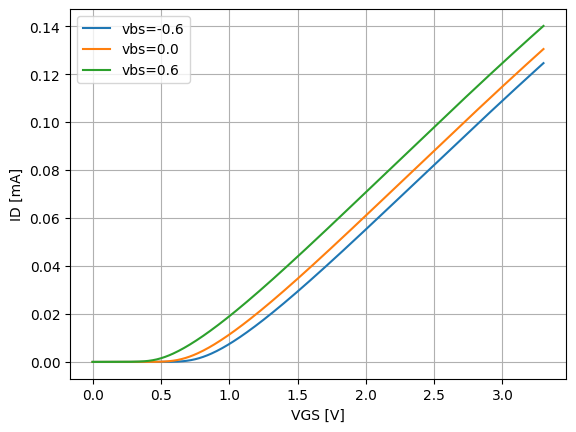

In [96]:
df = pd.read_csv("nfet_03v3_bodyeffect.txt", delim_whitespace=True, header=None)
df.columns = ["vgs", "id", "vgs_", "vbs"]
df['id_mA'] = df['id'] * 1000
results = {v: g.reset_index(drop=True) for v, g in df.groupby('vbs')}

for vbs_val, idvgs in results.items():
  plt.plot(idvgs['vgs'], idvgs['id_mA'], label=f'vbs={vbs_val}')
plt.xlabel('VGS [V]')
plt.ylabel('ID [mA]')
plt.legend()
plt.grid(True)
plt.show()

As shown in the graph above, VBS changes the threshold voltage $V_{\mathrm{th}}$. This is called *body effect*. If $V_{\mathrm{BS}}<0$ (the body potential is lower than that of the source), $V_{\mathrm{th}}$ increases. This biasing is called *reverse body bias (RBB)*. Oppositely, $V_{\mathrm{BS}}>0$ decreases $V_{\mathrm{th}}$, called *forward body bias (FBB)*.

**IMPORTANT:**
In SPICE, you can set body bias to any voltage and the circuit may work somehow. However in reality, MOSFETs never work when $V_{\mathrm{BS}}\gtrsim 0.6~\mathrm{V}$ beacause P-N junction to the substrate turns ON.

##3.2 ID-VGS of pMOS

pMOS works like nMOS, but the direction of the voltage and the current becomes opposite.

In [97]:
%%writefile pfet_03v3_idvgs.spice
* pMOS ID-VGS

.include "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/design.ngspice"
.lib "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/sm141064.ngspice" typical

XM1 net1 G vdd B pfet_03v3 L=0.28u W=0.22u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u' pd='2*int((nf+1)/2) * (W/nf + 0.18u)'
+ ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W' sa=0 sb=0 sd=0 m=1
VDD vdd GND 3.3
VBS vdd B 0
VGS vdd G 1.5
VDS vdd D 1.5
Vid net1 D 0

.option savecurrent
.control
save all
dc VGS 0 3.3 0.01
wrdata pfet_03v3_idvgs.txt i(Vid)
.endc
.end

Overwriting pfet_03v3_idvgs.spice


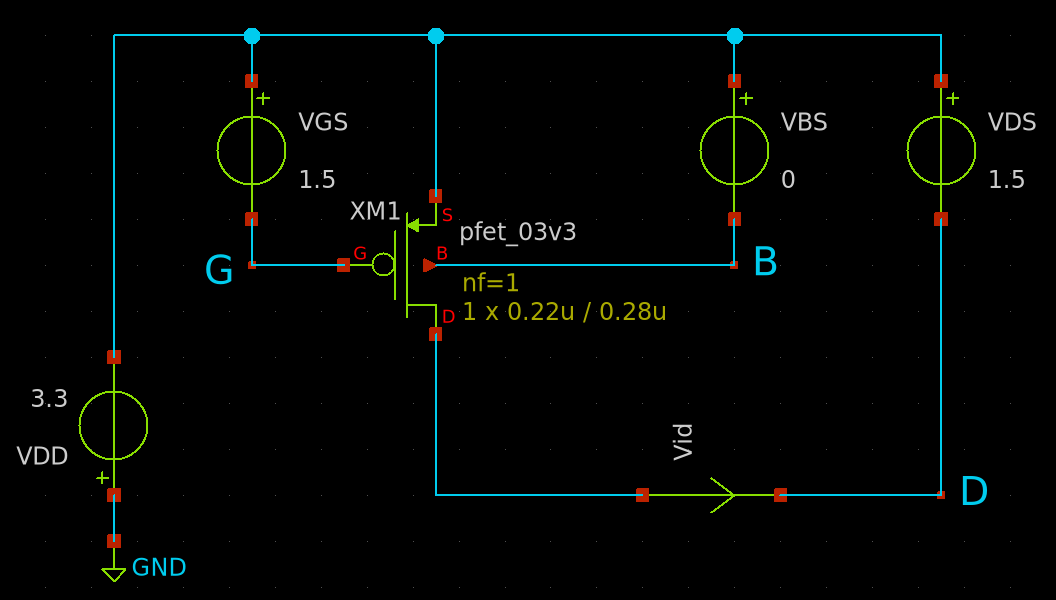

In [98]:
!ngspice -b pfet_03v3_idvgs.spice


Note: Compatibility modes selected: hs



Circuit: * pmos id-vgs

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


No. of Data Rows : 331
Note: Simulation executed from .control section 


/tmp/ipython-input-99-2424160796.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("pfet_03v3_idvgs.txt", delim_whitespace=True, header=None)


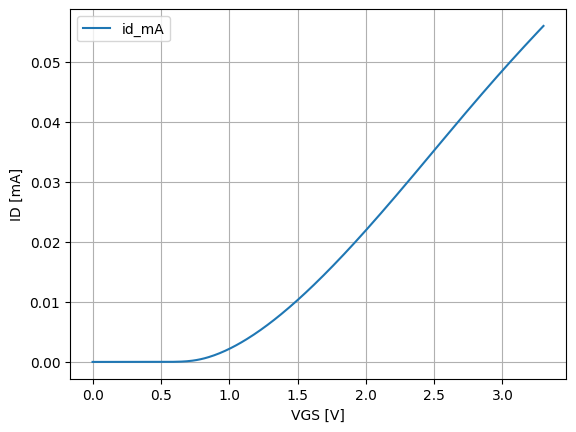

In [99]:
df = pd.read_csv("pfet_03v3_idvgs.txt", delim_whitespace=True, header=None)
df.columns = ["vgs", "id"]
df['id_mA'] = df['id'] * 1000


plt.plot(df['vgs'], df['id_mA'], label='id_mA')
plt.xlabel("VGS [V]")
plt.ylabel("ID [mA]")
plt.legend()
plt.grid(True)
plt.show()

In [100]:
%%writefile pfet_03v3_bodyeffect.spice
* pMOS ID-VGS with body bias

.include "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/design.ngspice"
.lib "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/sm141064.ngspice" typical

XM1 net1 G vdd B pfet_03v3 L=0.28u W=0.22u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u' pd='2*int((nf+1)/2) * (W/nf + 0.18u)'
+ ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W' sa=0 sb=0 sd=0 m=1
VDD vdd GND 3.3
VBS vdd B 0
VGS vdd G 1.5
VDS vdd D 1.5
Vid net1 D 0

.option savecurrent
.control
save all
dc VGS 0 3.3 0.01 VBS -0.6 0.6 0.6
wrdata pfet_03v3_bodyeffect.txt i(Vid) v(B)
.endc
.end

Overwriting pfet_03v3_bodyeffect.spice


In [101]:
!ngspice -b pfet_03v3_bodyeffect.spice


Note: Compatibility modes selected: hs



Circuit: * pmos id-vgs with body bias

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


No. of Data Rows : 993
Note: Simulation executed from .control section 


/tmp/ipython-input-102-2494414484.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("pfet_03v3_bodyeffect.txt", delim_whitespace=True, header=None)


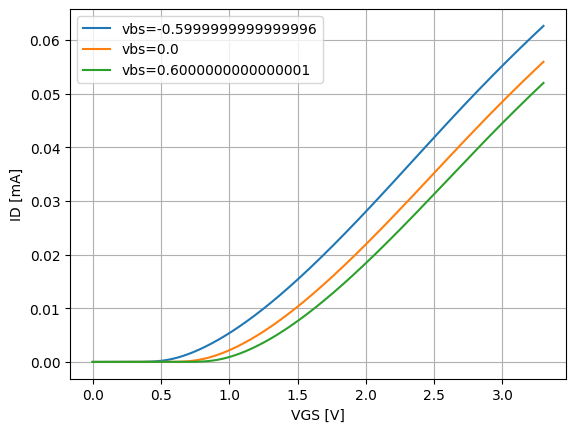

In [102]:
df = pd.read_csv("pfet_03v3_bodyeffect.txt", delim_whitespace=True, header=None)
df.columns = ["vgs", "id", "vgs_", "vb"]
df['id_mA'] = df['id'] * 1000
df['vbs']=df['vb'] - 3.3
results = {v: g.reset_index(drop=True) for v, g in df.groupby('vbs')}

for vbs_val, idvgs in results.items():
  plt.plot(idvgs['vgs'], idvgs['id_mA'], label=f'vbs={vbs_val}')
plt.xlabel('VGS [V]')
plt.ylabel('ID [mA]')
plt.legend()
plt.grid(True)
plt.show()

##4. ID-VDS Characteristics

In [103]:
%%writefile nfet_03v3_idvds.spice
* nMOS ID-VDS

.include "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/design.ngspice"
.lib "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/sm141064.ngspice" typical

XM1 net1 G GND B nfet_03v3 L=0.28u W=0.22u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u' pd='2*int((nf+1)/2) * (W/nf + 0.18u)'
+ ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W' sa=0 sb=0 sd=0 m=1
VBS B GND 0
VGS G GND 1.5
VDS D GND 1.5
Vid D net1 0

.option savecurrent
.control
save all
dc VDS 0 3.3 0.01 VGS 0 3.3 0.6
wrdata nfet_03v3_idvds.txt i(Vid) v(G)
.endc
.end

Overwriting nfet_03v3_idvds.spice


In [104]:
!ngspice -b nfet_03v3_idvds.spice


Note: Compatibility modes selected: hs



Circuit: * nmos id-vds

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


No. of Data Rows : 1986
Note: Simulation executed from .control section 


/tmp/ipython-input-105-2145309571.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("nfet_03v3_idvds.txt", delim_whitespace=True, header=None)


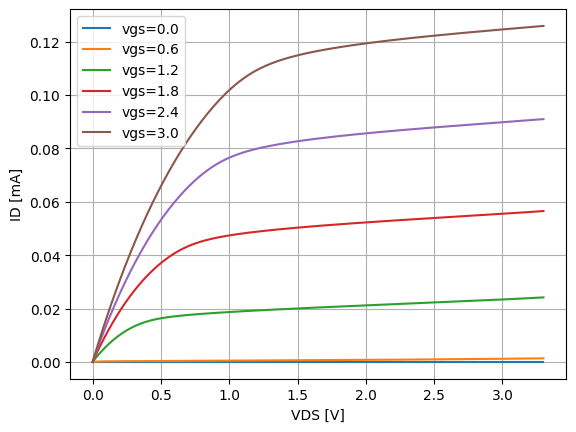

In [105]:
df = pd.read_csv("nfet_03v3_idvds.txt", delim_whitespace=True, header=None)
df.columns = ["vds", "id", "vds_", "vgs"]
df['id_mA'] = df['id'] * 1000
results = {v: g.reset_index(drop=True) for v, g in df.groupby('vgs')}

for vgs_val, idvds in results.items():
  plt.plot(idvds['vds'], idvds['id_mA'], label=f'vgs={vgs_val}')
plt.xlabel('VDS [V]')
plt.ylabel('ID [mA]')
plt.legend()
plt.grid(True)
plt.show()

In [106]:
%%writefile pfet_03v3_idvds.spice
* pMOS ID-VDS

.include "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/design.ngspice"
.lib "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/sm141064.ngspice" typical

XM1 net1 G vdd B pfet_03v3 L=0.28u W=0.22u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u' pd='2*int((nf+1)/2) * (W/nf + 0.18u)'
+ ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W' sa=0 sb=0 sd=0 m=1
VDD vdd GND 3.3
VBS vdd B 0
VGS vdd G 1.5
VDS vdd D 1.5
Vid net1 D 0

.option savecurrent
.control
save all
dc VDS 0 3.3 0.01 VGS 0 3.0 0.6
wrdata pfet_03v3_idvds.txt i(Vid) v(G)
.endc
.end

Overwriting pfet_03v3_idvds.spice


In [107]:
!ngspice -b pfet_03v3_idvds.spice


Note: Compatibility modes selected: hs



Circuit: * pmos id-vds

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


No. of Data Rows : 1986
Note: Simulation executed from .control section 


/tmp/ipython-input-108-3027668544.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("pfet_03v3_idvds.txt", delim_whitespace=True, header=None)


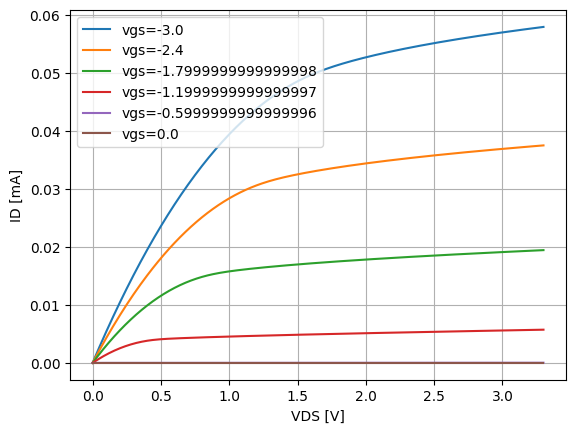

In [108]:
df = pd.read_csv("pfet_03v3_idvds.txt", delim_whitespace=True, header=None)
df.columns = ["vds", "id", "vds_", "vg"]
df['id_mA'] = df['id'] * 1000
df['vgs'] = df['vg'] - 3.3
results = {v: g.reset_index(drop=True) for v, g in df.groupby('vgs')}

for vgs_val, idvds in results.items():
  plt.plot(idvds['vds'], idvds['id_mA'], label=f'vgs={vgs_val}')
plt.xlabel('VDS [V]')
plt.ylabel('ID [mA]')
plt.legend()
plt.grid(True)
plt.show()

##5. Transconductance $g_{\mathrm{m}}$ / Output Conductance $g_{\mathrm{ds}}$

For analog circuit design, transconductance $g_{\mathrm{m}}$ and output conductance $g_{\mathrm{ds}}$ are very important characteristics.

The definitions are:

$$
g_{\mathrm{m}}=\frac{\partial I_{\mathrm{D}}}{\partial V_{\mathrm{GS}}}
$$
$$
g_{\mathrm{ds}}=\frac{\partial I_{\mathrm{D}}}{\partial V_{\mathrm{DS}}}
$$

$g_{\mathrm{m}}$ and $g_{\mathrm{ds}}$ are the slope of $I_{\mathrm{D}}$-$V_{\mathrm{GS}}$ curve and the slope of $I_{\mathrm{D}}$-$V_{\mathrm{DS}}$ curve, respectively. These depend on the operating point.
In the small signal equivalent circuit, $g_{\mathrm{m}}$ is the coefficient of the voltage-controlled current source. $1/g_{\mathrm{ds}}$ (written as $r_{\mathrm{ds}}$) is the output resistance of the current source. Thus, larger $g_{\mathrm{m}}$ is better, and smaller $g_{\mathrm{ds}}$ (larger $r_{\mathrm{ds}}$) is better.


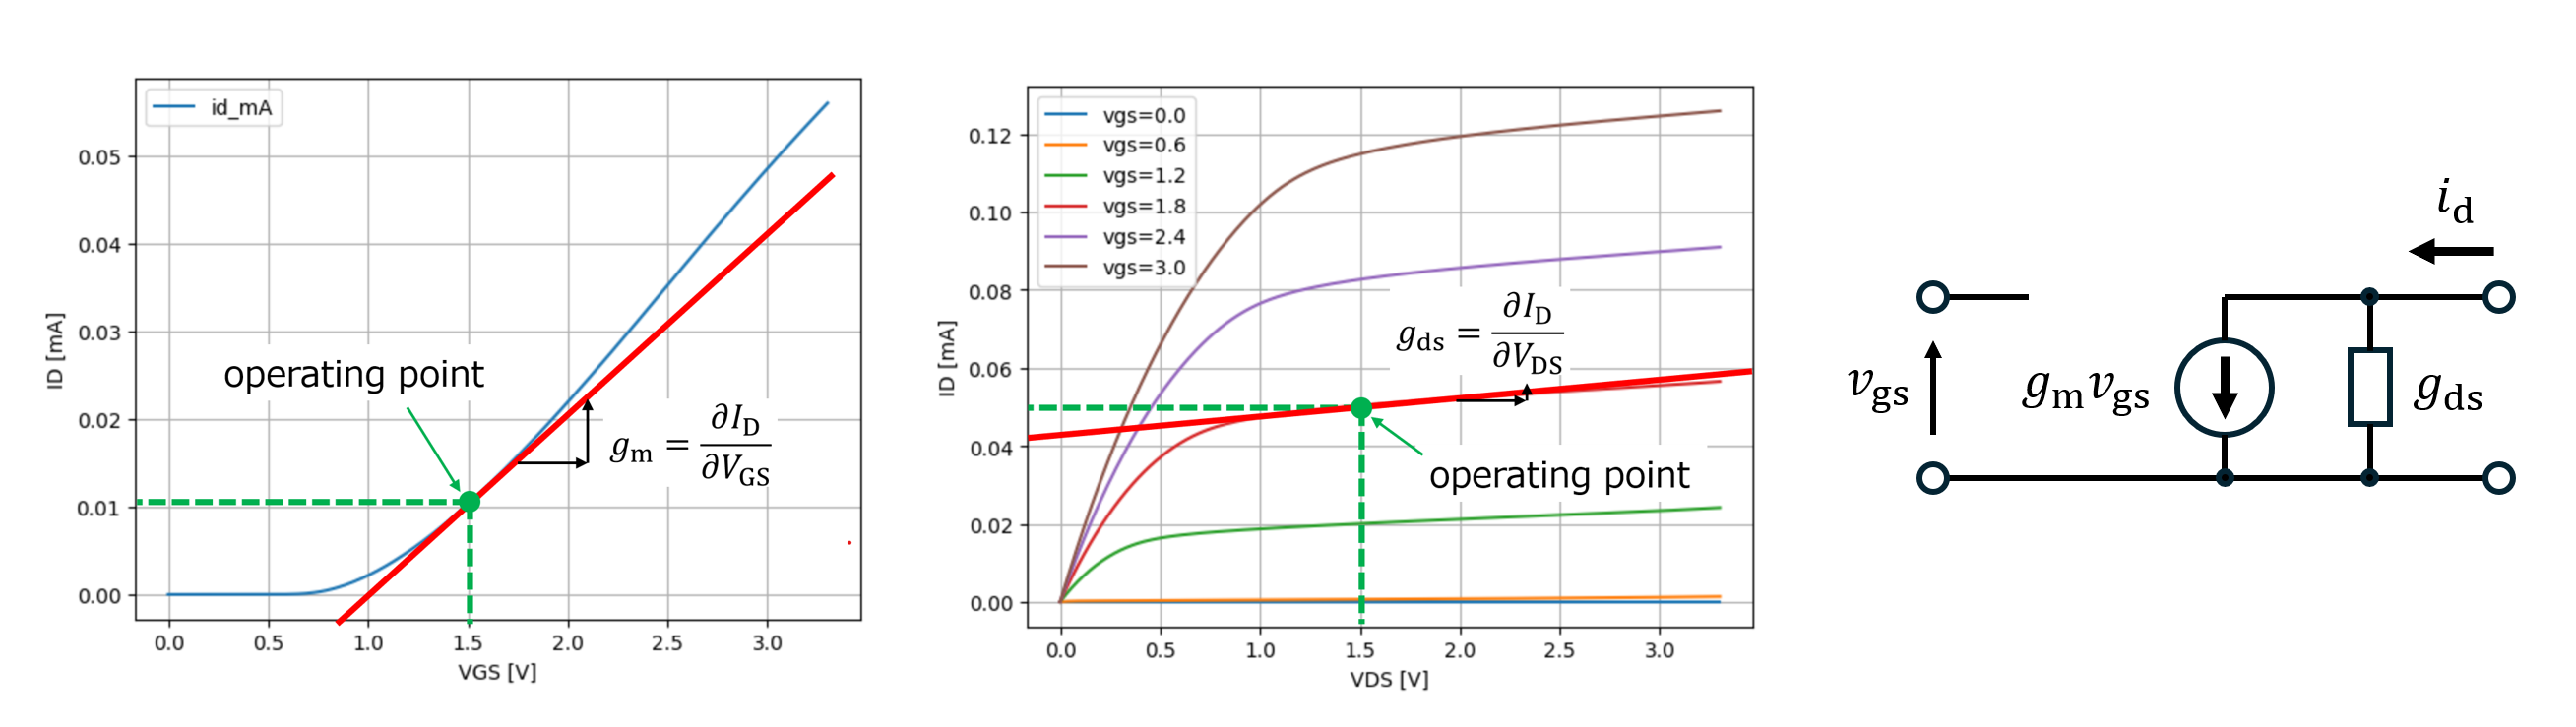

In [109]:
%%writefile nfet_03v3_gmvgs.spice
* nMOS gm-VGS

.include "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/design.ngspice"
.lib "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/sm141064.ngspice" typical

XM1 net1 G GND B nfet_03v3 L=0.28u W=0.22u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u' pd='2*int((nf+1)/2) * (W/nf + 0.18u)'
+ ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W' sa=0 sb=0 sd=0 m=1
VBS B GND 0
VGS G GND 1.5
VDS D GND 1.5
Vid D net1 0

.option savecurrent
.control
save all @m.XM1.m0[gm] @m.XM1.m0[gds]
dc VGS 0 3.3 0.01
wrdata nfet_03v3_gmvgs.txt @m.XM1.m0[gm] @m.XM1.m0[gds] i(Vid)
.endc
.end

Overwriting nfet_03v3_gmvgs.spice


In [110]:
!ngspice -b nfet_03v3_gmvgs.spice


Note: Compatibility modes selected: hs



Circuit: * nmos gm-vgs

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


No. of Data Rows : 331
Note: Simulation executed from .control section 


/tmp/ipython-input-111-4221409581.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("nfet_03v3_gmvgs.txt", delim_whitespace=True, header=None)


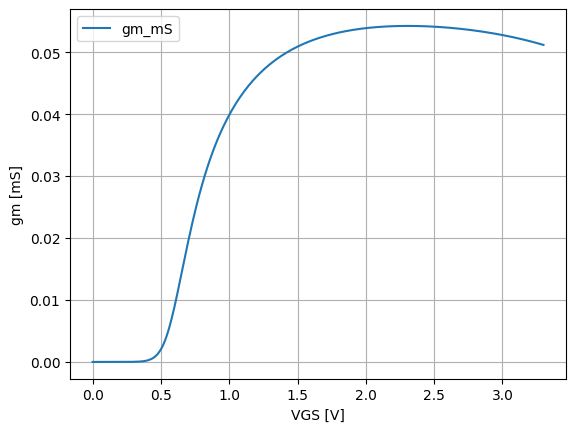

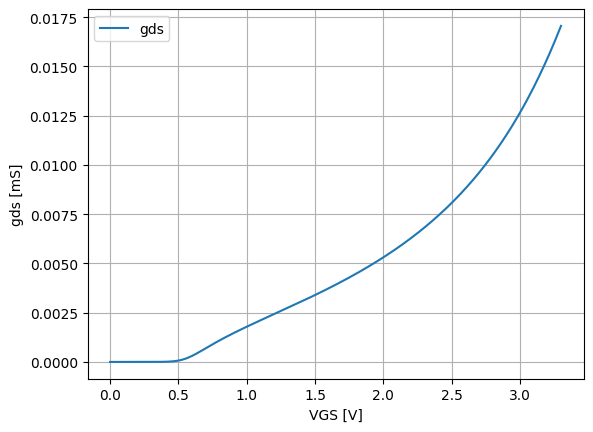

In [111]:
df = pd.read_csv("nfet_03v3_gmvgs.txt", delim_whitespace=True, header=None)
df.columns = ["vgs", "gm", "vgs_", "gds", "vgs__", "id"]
df['gm_mS'] = df['gm'] * 1000
df['gds_mS'] = df['gds'] * 1000
df['id_mA'] = df['id'] * 1000

plt.plot(df['vgs'], df['gm_mS'], label='gm_mS')
plt.xlabel("VGS [V]")
plt.ylabel("gm [mS]")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(df['vgs'], df['gds_mS'], label='gds')
plt.xlabel("VGS [V]")
plt.ylabel("gds [mS]")
plt.legend()
plt.grid(True)
plt.show()



As shown above, $g_{\mathrm{m}}$ becomes larger as $V_{\mathrm{GS}}$ becomes larger. Then, larger $V_{\mathrm{GS}}$ is better for analog circuits? The answer is NO. Now let's look into $g_{\mathrm{m}}/I_{\mathrm{D}}$. $I_{\mathrm{D}}$ is the bias current, so it corresponds to the power consumption. So, $g_{\mathrm{m}}/I_{\mathrm{D}}$ is a kind of power efficiency.

As shown below, $g_{\mathrm{m}}/I_{\mathrm{D}}$ becomes maximum at weak inversion region ($V_{\mathrm{GS}}<V_{\mathrm{th}}$).

For detail of $g_{\mathrm{m}}/I_{\mathrm{D}}$, please refer Prof. Murmann's book (and his lecture).

P. G. A. Jespers and B. Murmann, "Systematic Design of Analog CMOS Circuits: Using Pre-Computed Lookup Tables," Cambridge University Press, 2017.
[https://github.com/bmurmann/Book-on-gm-ID-design]

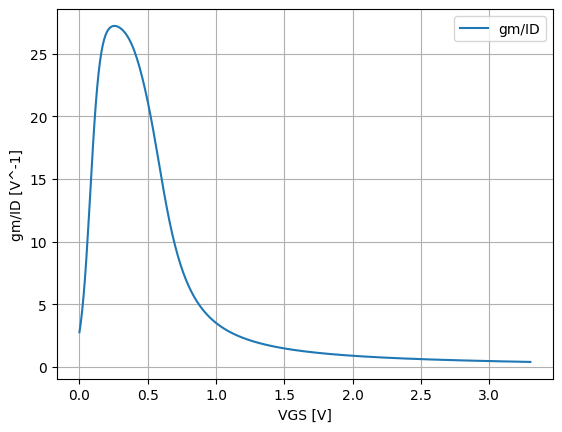

In [112]:
plt.plot(df['vgs'], df['gm_mS']/df['id_mA'], label='gm/ID')
plt.xlabel("VGS [V]")
plt.ylabel("gm/ID [V^-1]")
plt.legend()
plt.grid(True)
plt.show()

Also, an important measure is $g_{\mathrm{m}}/g_{\mathrm{ds}}$ ($= g_{\mathrm{m}}r_{\mathrm{ds}}$), called *intrinsic gain*. This is the maximum gain at the operating point.

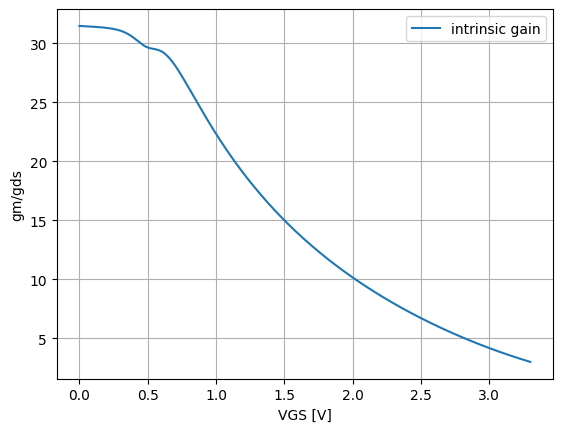

In [113]:
plt.plot(df['vgs'], df['gm_mS'] / df['gds_mS'], label='intrinsic gain')
plt.xlabel("VGS [V]")
plt.ylabel("gm/gds")
plt.legend()
plt.grid(True)
plt.show()

Now evaluate pMOS.

In [117]:
%%writefile pfet_03v3_gmvgs.spice
* pMOS gm-VGS

.include "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/design.ngspice"
.lib "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/sm141064.ngspice" typical

XM1 net1 G vdd B pfet_03v3 L=0.28u W=0.22u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u' pd='2*int((nf+1)/2) * (W/nf + 0.18u)'
+ ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W' sa=0 sb=0 sd=0 m=1
VDD vdd GND 3.3
VBS vdd B 0
VGS vdd G 1.5
VDS vdd D 1.5
Vid net1 D 0

.option savecurrent
.control
save all @m.XM1.m0[gm] @m.XM1.m0[gds]
dc VGS 0 3.3 0.01
wrdata pfet_03v3_gmvgs.txt @m.XM1.m0[gm] @m.XM1.m0[gds] i(Vid)
.endc
.end

Overwriting pfet_03v3_gmvgs.spice


In [118]:
!ngspice -b pfet_03v3_gmvgs.spice


Note: Compatibility modes selected: hs



Circuit: * pmos gm-vgs

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


No. of Data Rows : 331
Note: Simulation executed from .control section 


/tmp/ipython-input-119-811032410.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("pfet_03v3_gmvgs.txt", delim_whitespace=True, header=None)


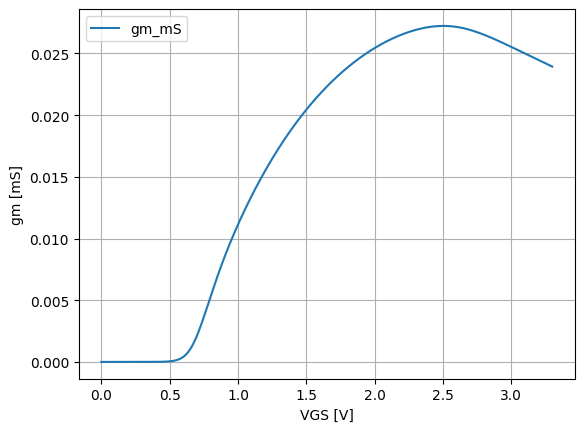

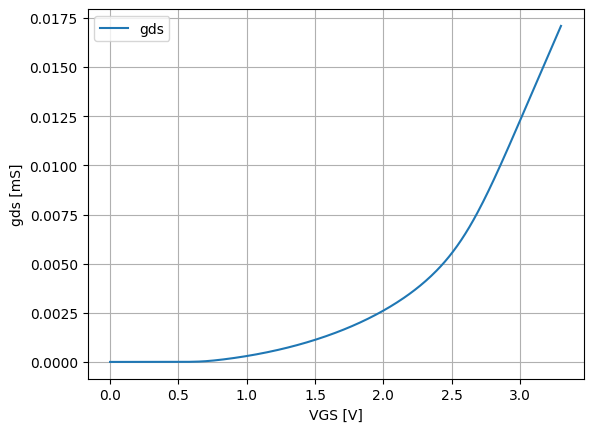

In [119]:
df = pd.read_csv("pfet_03v3_gmvgs.txt", delim_whitespace=True, header=None)
df.columns = ["vgs", "gm", "vgs_", "gds", "vgs__", "id"]
df['gm_mS'] = df['gm'] * 1000
df['gds_mS'] = df['gds'] * 1000
df['id_mA'] = df['id'] * 1000


plt.plot(df['vgs'], df['gm_mS'], label='gm_mS')
plt.xlabel("VGS [V]")
plt.ylabel("gm [mS]")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(df['vgs'], df['gds_mS'], label='gds')
plt.xlabel("VGS [V]")
plt.ylabel("gds [mS]")
plt.legend()
plt.grid(True)
plt.show()

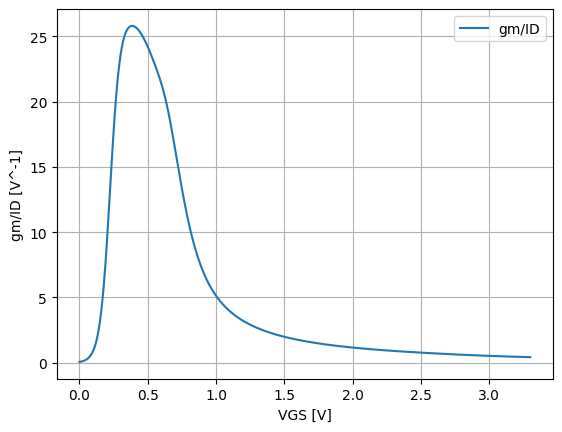

In [120]:
plt.plot(df['vgs'], df['gm_mS']/df['id_mA'], label='gm/ID')
plt.xlabel("VGS [V]")
plt.ylabel("gm/ID [V^-1]")
plt.legend()
plt.grid(True)
plt.show()

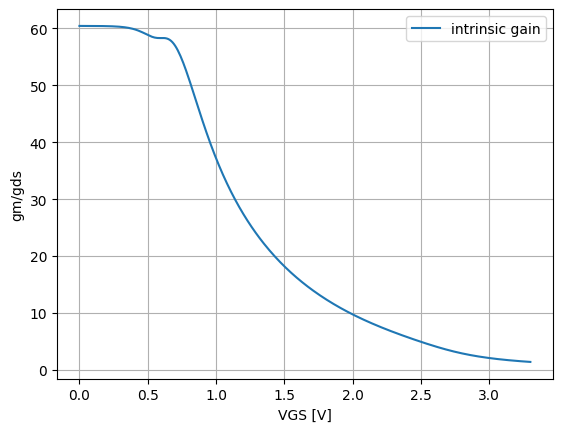

In [121]:
plt.plot(df['vgs'], df['gm_mS'] / df['gds_mS'], label='intrinsic gain')
plt.xlabel("VGS [V]")
plt.ylabel("gm/gds")
plt.legend()
plt.grid(True)
plt.show()